#  Load Libraries

In [28]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from xgboost import XGBClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

* Read data and check data by head()

In [29]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


* Check data info and statistics by describe()

In [30]:
df.info()
print('-'*60)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
------------------------------------------------------------


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Good!. There is no missing value and all features type are number.

In [31]:
df.shape

(768, 9)

# EDA by visualization

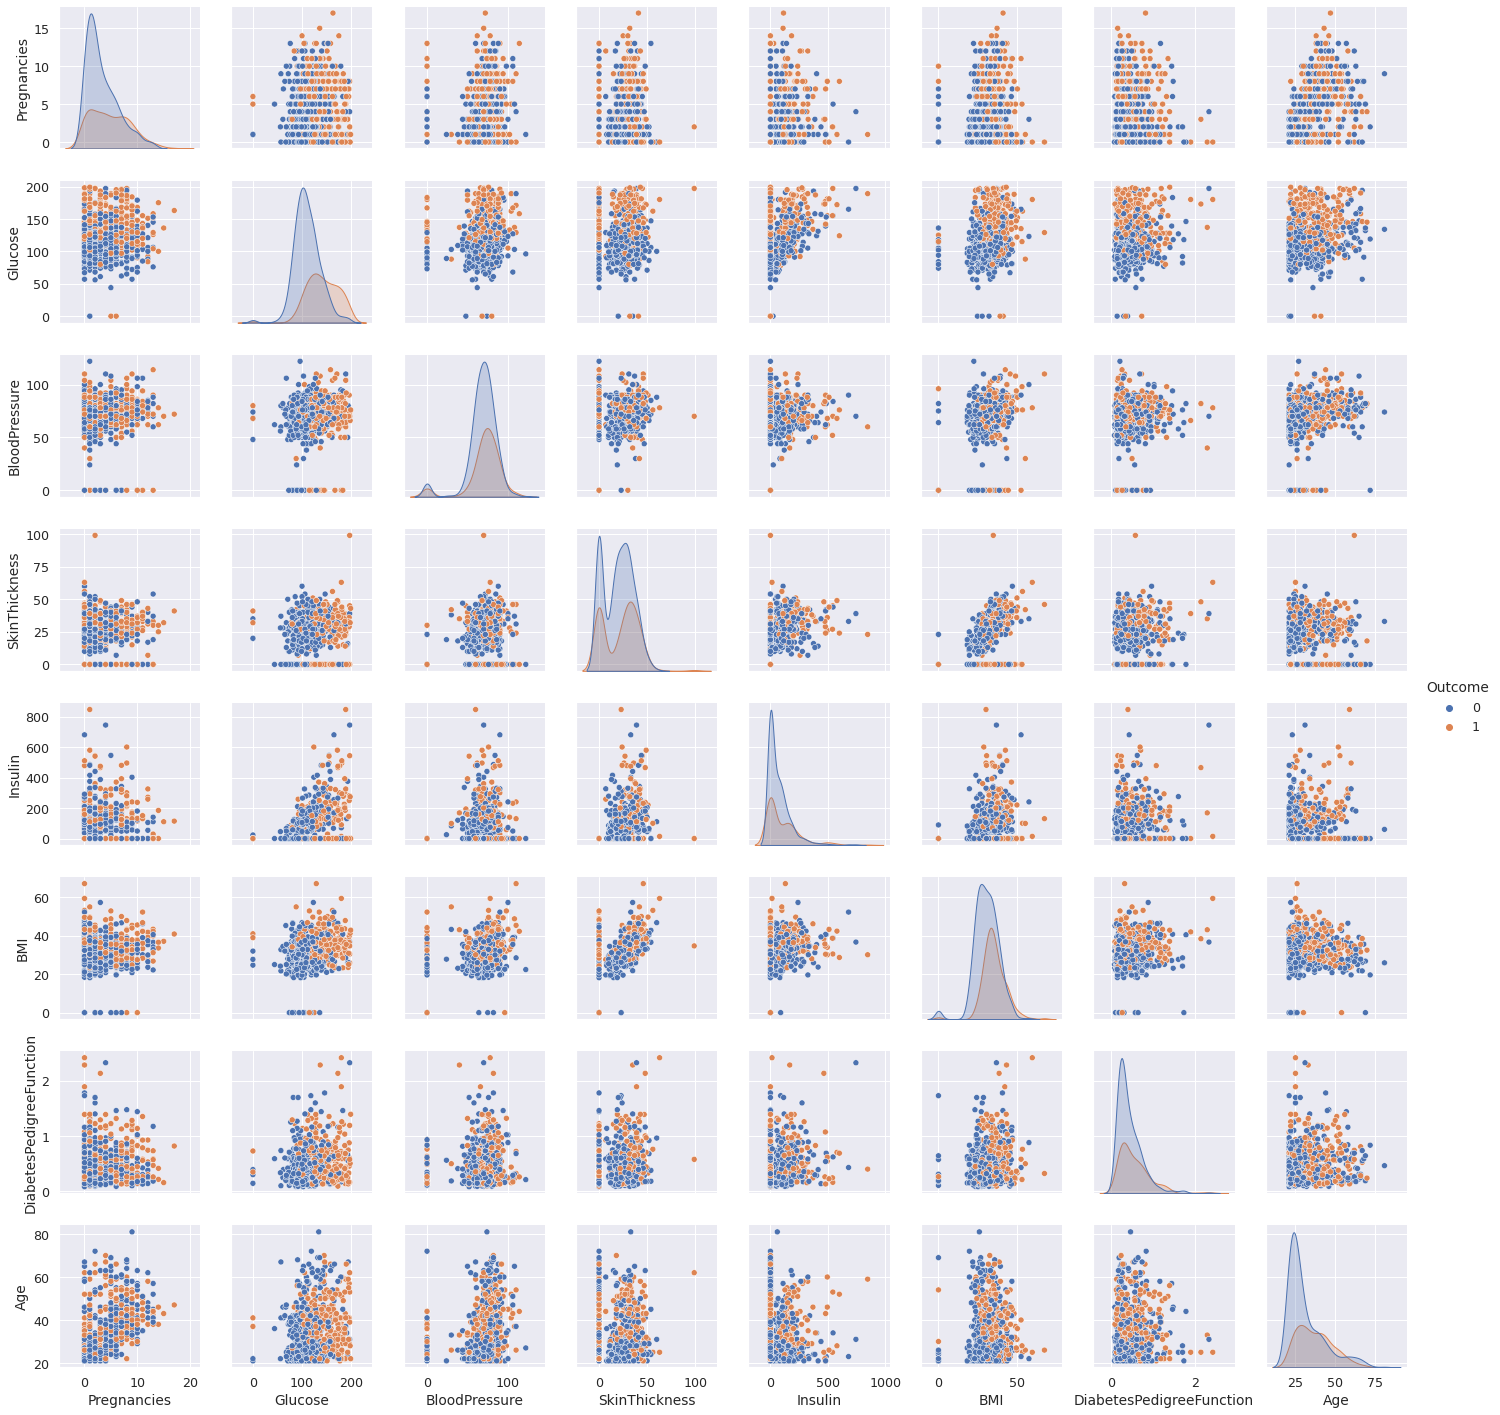

In [32]:
sns.pairplot(data=df,hue='Outcome')

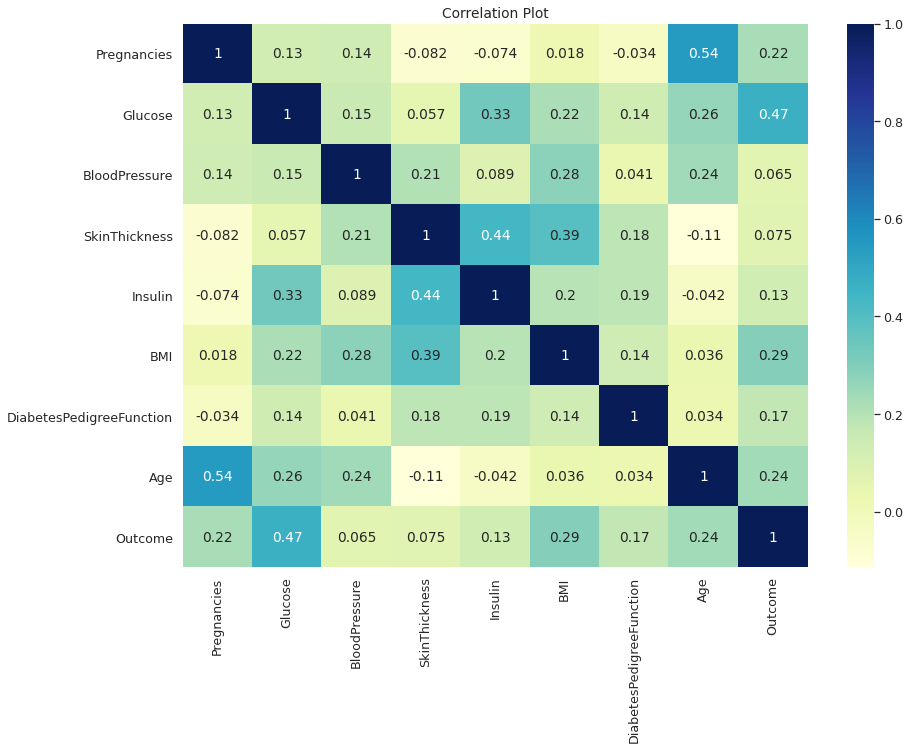

In [33]:
corr=df.corr()

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))

sns.heatmap(corr,annot=True,cmap='YlGnBu')
plt.title('Correlation Plot');

Outcome는 Glucose와 상관계수가 0.47로 상관이 높아 보입니다.

#  Modeling

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


Splitting the data into X and y

In [35]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [46]:
X_train.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

* To take advantage of the ensemble, we will use the gradient boost classifier.

In [37]:
#Model
gb =  GradientBoostingClassifier()

#fiting the model
gb.fit(X_train, y_train)

#prediction
y_pred = gb.predict(X_test)

#Accuracy
print("Accuracy ", gb.score(X_test, y_test)*100)


Accuracy  75.0


# Exporting Model

Export model in pickel file
Pickle in Python is primarily used in serializing and deserializing a Python object structure. In other words, it's the process of converting a Python object into a byte stream to store it in a file/database, maintain program state across sessions, or transport data over the network.

In [38]:
import joblib
os.makedirs('display', exist_ok=True)
joblib.dump(value=gb, filename='display/gb.pkl')

['display/gb.pkl']

# MODEL DEPLOYEMENT

1. Set up your testing environment
2. Retrieve the model from your workspace
3. Test the model locally
4. Deploy the model to ACI
5. Test the deployed model

# 1. Registering Model

The Workspace class is a foundational resource in the cloud that you use to experiment, train, and deploy machine learning models. It ties your Azure subscription and resource group to an easily consumed object.
Import the class and create a new workspace by using the following code. Set create_resource_group to False if you have a previously existing Azure resource group that you want to use for the workspace.

After that creating and Environment
Azure Machine Learning environments specify the Python packages, environment variables, and software settings around your training and scoring scripts.

You can use an Environment object to:

1. Develop your training script.
2. Reuse the same environment on Azure Machine Learning Compute for model training at scale.
3. Deploy your model with that same environment without being tied to a specific compute type.

Then downloading all conda Dependencies and register the workspace


In [39]:
from azureml.core import Workspace
ws = Workspace.from_config()

from azureml.core.model import Model
model_name = "GB_MODEL"
model = Model.register(model_path="display/gb.pkl",
                        model_name=model_name,
                        tags={"data": "Diabetes", "model": "classification"},
                        description="NA",
                        workspace=ws)

from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
myenv = Environment('deplo-env')

cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'], conda_packages = ['scikit-learn==0.22.1'])

myenv.python.conda_dependencies = cd

# Register environment to re-use later
myenv.register(workspace = ws)
print("environment susccesfully register")

Registering model GB_MODEL
environment susccesfully register


In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
import azureml.core

# display the core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.31.0


# 2. Writing Score.py file

Create the scoring script, called score.py, used by the web service call to show how to use the model.

The init() function, which typically loads the model into a global object. This function is run only once when the Docker container is started.

The run(input_data) function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization, but other formats are supported.m

In [41]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
import joblib
from azureml.core.model import Model


def init():
    global model0
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    model_path = Model.get_model_path('GB_MODEL',2)
    model = joblib.load(model_path)


def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Overwriting score.py


# ACI Webservice

Deploy the model as a web service hosted in ACI.

To build the correct environment for ACI, provide the following:

1. A scoring script to show how to use the model
2. A configuration file to build the ACI
3. The model you trained before

In [42]:
from azureml.core.webservice import AciWebservice
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)

# Final Deployment

Estimated time to complete: about 2-5 minutes

Configure the image and deploy. The following code goes through these steps:

1. Create environment object containing dependencies needed by the model using the environment file (myenv.yml)
2. Create inference configuration necessary to deploy the model as a web service using:   
i. The scoring file (score.py)
ii. envrionment object created in previous step
3.Deploy the model to the ACI container.
4.Get the web service HTTP endpoint.

A universally unique identifier (UUID) is a 128-bit label used for information in computer systems. The term globally unique identifier (GUID) is also used, often in software created by Microsoft.

When generated according to the standard methods, UUIDs are, for practical purposes, unique. Their uniqueness does not depend on a central registration authority or coordination between the parties generating them, unlike most other numbering schemes. While the probability that a UUID will be duplicated is not zero, it is close enough to zero to be negligible.

In [44]:
import uuid
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
model = Model(ws, 'GB_MODEL')

env = Environment.get(workspace=ws, name="deplo-env",version="2")
inference_config = InferenceConfig(entry_script="score.py", environment=env)

service_name = 'gb-' + str(uuid.uuid4())[:4]
service = Model.deploy(workspace=ws, 
                       name=service_name, 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-10-12 16:36:29+00:00 Creating Container Registry if not exists.
2021-10-12 16:36:29+00:00 Registering the environment.
2021-10-12 16:36:30+00:00 Use the existing image.
2021-10-12 16:36:30+00:00 Generating deployment configuration.
2021-10-12 16:36:31+00:00 Submitting deployment to compute.
2021-10-12 16:36:35+00:00 Checking the status of deployment gb-7add..
2021-10-12 16:38:13+00:00 Checking the status of inference endpoint gb-7add.
Succeeded
ACI service creation operation finished, operation "Succeeded"


Final Deployment Completed.......

# Testing Endpoints

In [60]:
import requests
import json

headers = {'Content-Type':'application/json'}

if service.auth_enabled:
    headers['Authorization'] = 'Bearer '+service.get_keys()

print(headers)


test_sample = json.dumps({'data': [[1,85,66,29,0,26.6,0.351,31]]})


response = requests.post(service.scoring_uri, data=test_sample, headers=headers)
print(response.status_code)
print(response.elapsed)
#print(response.json())

{'Content-Type': 'application/json'}
502
0:00:00.040762
